# Dataset 5 

Using 4 CLusters vs. 3 Clusters
Since the real spikes are only few in number the k means algo with just 3 cluster centers fails to separate the dataset, see the PCA plot below

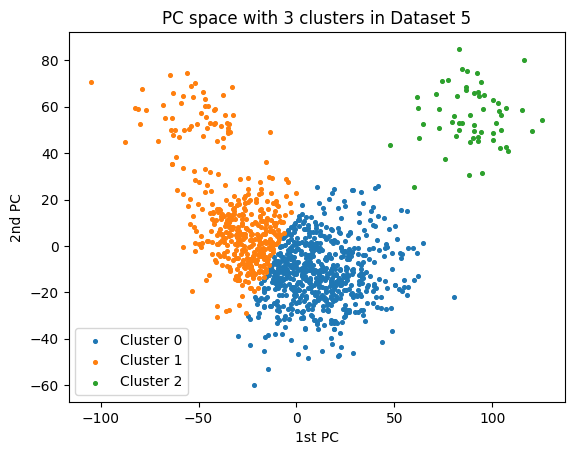

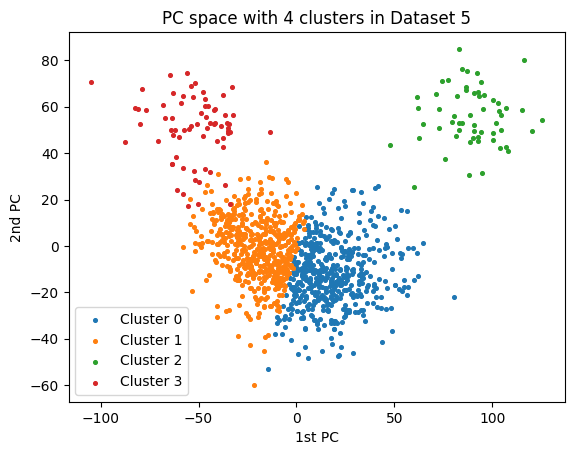

In [5]:
import scipy.signal, scipy.io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
%matplotlib inline

def plotDataSection(data, title, startTime=0, endTime=None, sampleRate=24e3, threshold = None):
    if endTime is None:
        time = np.linspace(0, len(data)/sampleRate, num=len(data))
        data_section = data
    else:
        idxStart = int(startTime*sampleRate)
        idxEnd = int(endTime*sampleRate)
        data_section = data[idxStart: idxEnd]
        time = np.linspace(startTime, endTime, num=(idxEnd - idxStart))
    fig, ax = plt.subplots()
    if threshold is not None:
        ax.axhline(y=threshold, color ='r', linestyle =':', linewidth = 3)
    
        fig.set_size_inches(20,5)
    ax.plot(time, data_section)
    ax.set_title(title)
    ax.set_xlabel('time [s]')
    ax.set_ylabel('voltage [uv]')
    ax.grid(True)

    
    return fig, ax

def plotSectionMeanAndSTD(data, title, sampleRate=24e3):
    dataMean = data.mean(axis=0)
    time = np.linspace(0, len(dataMean)/sampleRate, num=len(dataMean))
    dataSTD = data.std(axis=0)
    fig, ax1 = plt.subplots()
    ax1.plot(time, dataMean, color='b')
    ax1.plot(time, dataMean + dataSTD, 'r.')
    ax1.plot(time, dataMean - dataSTD, 'r.')
    ax1.set_title(title)
    ax1.set_xlabel('time [s]')
    ax1.set_ylabel('voltage [uv]')
    ax1.grid(True)
    # ax2 = fig.add_subplot(212)
    # ax2.plot(time, dataSTD)
    # ax2.set_xlabel('time [s]')
    # ax2.set_ylabel('STD')
    # ax2.grid(True)

def getPeakSections(data, idxPeaks, windowSizeBefore, windowSizeAfter):
    peakSections = []
    for i in idxPeaks:
        peakSections.append(data[i - windowSizeBefore: i + windowSizeAfter])
    return np.array(peakSections)

def removeOutOfBoundIdx(idx, lowBound, upBound):
    '''Remove the idx that are too close to the begining or end 
    defined by lowBound and upBound.
    Needed to avoid index out of bound error when cutting data into small sections.
    '''
    return idx[np.logical_and(idx > lowBound, idx < upBound)]

def visualize_alignment(data, cluster_center = None, title = ' ', groundTruth = None):
    time = np.linspace(0, len(data[0])/sampleRate, num=len(data[0]))
    fig, ax1 = plt.subplots()
    for x in data:
        ax1.set_title(title)
        ax1.plot(time, x, color='b', linewidth=0.15)
        ax1.set_xlabel('time [s]')
        ax1.set_ylabel('voltage [uv]')
        ax1.grid(True)
    if cluster_center is not None:
        ax1.plot(time, cluster_center, color= 'aqua', linewidth = 4, label = f'Average Spike form ({len(data)} spikes)')
    if groundTruth is not None:
        dataMean = groundTruth.mean(axis=0)
        ax1.plot(time, dataMean, color = 'orange', linewidth = 2, label = f'Average Ground truth ({len(groundTruth)} spikes)')
    ax1.legend()

dataset = 5
sampleRate = 24e3
heightThreshold = 40
distanceThreshold = 10
numSpikeTypes = 3
dataFile = ['sample_1.mat', 'sample_2.mat', 'sample_3.mat', 'sample_4.mat', 'sample_5.mat']
filtering = [True, True, True, True, True]
median_mult = [4, 4, 5, 5, 4]
numPC = 2
numSpikes = [3, 3, 3, 3, 4]
windowSizeBefore_0 = [ 8,  8,  8,  8,  8]
windowSizeAfter_0 =  [64, 64, 64, 64, 64]

windowSizeBefore_1 = [11, 10, 10, 10, 10]
windowSizeAfter_1 =  [61, 62, 62, 62, 62]

windowSizeBefore_2 = [ 4, 11, 10,  4,  3]
windowSizeAfter_2 =  [68, 61, 62, 68, 69]


dataset -=1 ## decrease the variable by one, such that one does not have to do this in every bracket hereafter

data = scipy.io.loadmat(dataFile[dataset])
origData = data['data'].flatten()
spike_times = data['spike_times'][0][0][0]
spike_class = data['spike_class'][0][0][0]
windowSizeBefore = 30
windowSizeAfter = 70
spike_times_type0 = spike_times[np.where(spike_class == 0)]
spike_times_type0 = removeOutOfBoundIdx(
    spike_times_type0, windowSizeBefore, len(origData) - windowSizeAfter - 80)

spike_times_type1 = spike_times[np.where(spike_class == 1)]
spike_times_type1 = removeOutOfBoundIdx(
    spike_times_type1, windowSizeBefore, len(origData) - windowSizeAfter - 80)

spike_times_type2 = spike_times[np.where(spike_class == 2)]
spike_times_type2 = removeOutOfBoundIdx(
    spike_times_type2, windowSizeBefore, len(origData) - windowSizeAfter - 80)

recLength = len(origData) / sampleRate

sos = scipy.signal.iirfilter(2, [300,3000], btype='bandpass',ftype='butter', rp=3000, rs=300, output='sos',fs=sampleRate)
filteredData = scipy.signal.sosfiltfilt(sos, origData)

if filtering[dataset]:
    data_to_use = filteredData
else:
    data_to_use = origData

spikeSectionType0 = getPeakSections(data_to_use, spike_times_type0, 
    windowSizeBefore_0[dataset], windowSizeAfter_0[dataset])
spikeSectionType1 = getPeakSections(data_to_use, spike_times_type1, 
    windowSizeBefore_1[dataset], windowSizeAfter_1[dataset])
spikeSectionType2 = getPeakSections(data_to_use, spike_times_type2, 
    windowSizeBefore_2[dataset], windowSizeAfter_2[dataset])

median = np.median(np.abs(data_to_use)/0.6745)
heightThreshold = median_mult[dataset] * median
distanceThreshold = 72

idxPeaks, peakProperties = scipy.signal.find_peaks(
    data_to_use, height=heightThreshold, distance=distanceThreshold)
idxPeaks = idxPeaks[idxPeaks > windowSizeBefore]

peakSections = getPeakSections(filteredData, idxPeaks, windowSizeBefore, windowSizeAfter)

numPC = 3

pca = PCA(n_components=numPC)
pca.fit(peakSections)
peakPC = pca.transform(peakSections)

for i in range(3,5):
    numSpikeTypes = i

    kMeanCluster = KMeans(n_clusters=numSpikeTypes, n_init=10)
    kMeanCluster.fit(peakPC)

    fig, ax = plt.subplots()
    for idxCluster in range(numSpikeTypes):
        clusterPC = peakPC[kMeanCluster.labels_ == idxCluster]
        ax.scatter(clusterPC[:, 0], clusterPC[:, 1], label=f'Cluster {idxCluster}', s = 7)
    ax.set_xlabel("1st PC")
    ax.set_ylabel("2nd PC")
    ax.set_title(f'PC space with {i} clusters in Dataset 5')
    ax.legend()

# Dataset 3/4

In the PC space the data is densely packed into 1 blob. Increasing the Height Threshold decreases the amount of type 0 spikes. With the highest threshold mostly type 1 and 2 spikes remain in clearer clusters.

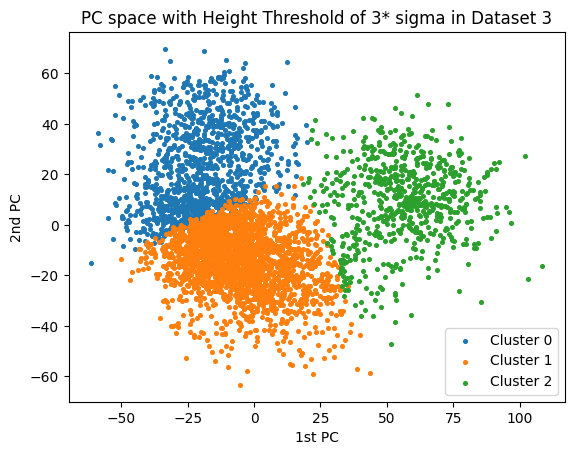

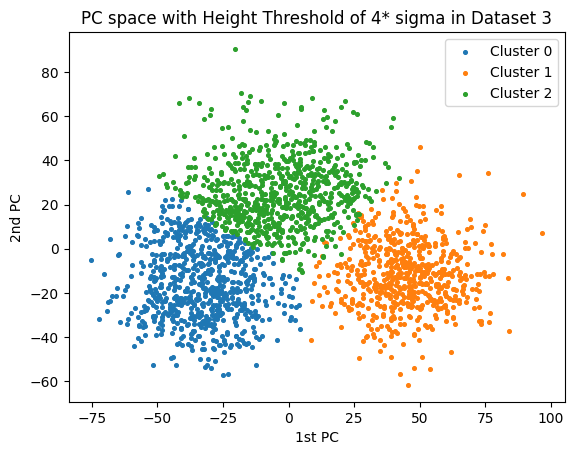

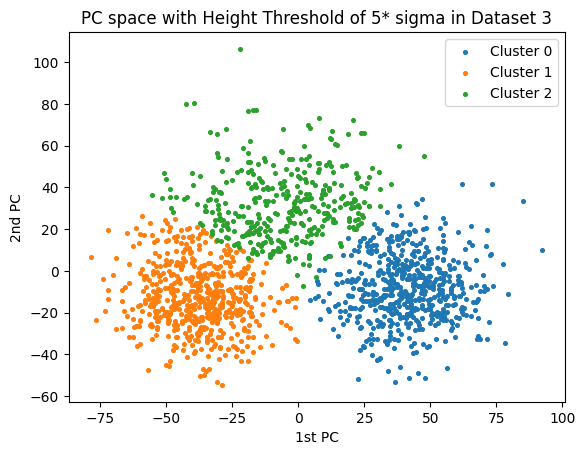

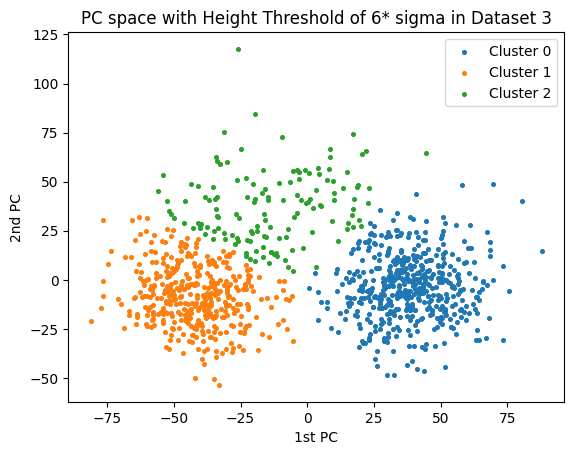

In [8]:
dataset = 4
sampleRate = 24e3
heightThreshold = 40
distanceThreshold = 10
numSpikeTypes = 3
dataFile = ['sample_1.mat', 'sample_2.mat', 'sample_3.mat', 'sample_4.mat', 'sample_5.mat']
filtering = [True, True, True, True, True]
median_mult = [4, 4, 5, 5, 4]
numPC = 2
numSpikes = [3, 3, 3, 3, 4]
windowSizeBefore_0 = [ 8,  8,  8,  8,  8]
windowSizeAfter_0 =  [64, 64, 64, 64, 64]

windowSizeBefore_1 = [11, 10, 10, 10, 10]
windowSizeAfter_1 =  [61, 62, 62, 62, 62]

windowSizeBefore_2 = [ 4, 11, 10,  4,  3]
windowSizeAfter_2 =  [68, 61, 62, 68, 69]


dataset -=1 ## decrease the variable by one, such that one does not have to do this in every bracket hereafter

data = scipy.io.loadmat(dataFile[dataset])
origData = data['data'].flatten()
spike_times = data['spike_times'][0][0][0]
spike_class = data['spike_class'][0][0][0]
windowSizeBefore = 30
windowSizeAfter = 70
spike_times_type0 = spike_times[np.where(spike_class == 0)]
spike_times_type0 = removeOutOfBoundIdx(
    spike_times_type0, windowSizeBefore, len(origData) - windowSizeAfter - 80)

spike_times_type1 = spike_times[np.where(spike_class == 1)]
spike_times_type1 = removeOutOfBoundIdx(
    spike_times_type1, windowSizeBefore, len(origData) - windowSizeAfter - 80)

spike_times_type2 = spike_times[np.where(spike_class == 2)]
spike_times_type2 = removeOutOfBoundIdx(
    spike_times_type2, windowSizeBefore, len(origData) - windowSizeAfter - 80)

recLength = len(origData) / sampleRate

sos = scipy.signal.iirfilter(2, [300,3000], btype='bandpass',ftype='butter', rp=3000, rs=300, output='sos',fs=sampleRate)
filteredData = scipy.signal.sosfiltfilt(sos, origData)

if filtering[dataset]:
    data_to_use = filteredData
else:
    data_to_use = origData

spikeSectionType0 = getPeakSections(data_to_use, spike_times_type0, 
    windowSizeBefore_0[dataset], windowSizeAfter_0[dataset])
spikeSectionType1 = getPeakSections(data_to_use, spike_times_type1, 
    windowSizeBefore_1[dataset], windowSizeAfter_1[dataset])
spikeSectionType2 = getPeakSections(data_to_use, spike_times_type2, 
    windowSizeBefore_2[dataset], windowSizeAfter_2[dataset])


for i in range(3,7):
    median = np.median(np.abs(data_to_use)/0.6745)
    heightThreshold = i *  median
    distanceThreshold = 72

    idxPeaks, peakProperties = scipy.signal.find_peaks(
        data_to_use, height=heightThreshold, distance=distanceThreshold)
    idxPeaks = idxPeaks[idxPeaks > windowSizeBefore]

    peakSections = getPeakSections(filteredData, idxPeaks, windowSizeBefore, windowSizeAfter)

    numPC = 3

    pca = PCA(n_components=numPC)
    pca.fit(peakSections)
    peakPC = pca.transform(peakSections)


    numSpikeTypes = numSpikes[dataset]

    kMeanCluster = KMeans(n_clusters=numSpikeTypes, n_init=10)
    kMeanCluster.fit(peakPC)

    fig, ax = plt.subplots()
    for idxCluster in range(numSpikeTypes):
        clusterPC = peakPC[kMeanCluster.labels_ == idxCluster]
        ax.scatter(clusterPC[:, 0], clusterPC[:, 1], label=f'Cluster {idxCluster}', s = 7)
    ax.set_xlabel("1st PC")
    ax.set_ylabel("2nd PC")
    ax.set_title(f'PC space with Height Threshold of {i}* sigma in Dataset {dataset}')
    ax.legend()